# Created by Wenhan Hua
Feb 10th. 2023

In [1]:
# Load the needed package
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import cmath
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from decimal import *
from tqdm import tqdm

Setting the motional constant of the e:
- $\omega_{rf} = \omega_{mm} = 10 GHz $
- $\omega_{radical} = 2 GHz $
- $\omega_{axial} = 300 MHz $
- $ d_{eff} = 200e-6 m $
- $ m = 9.10938297e-31 kg $
- $ q = 1.6e-19 $

In [2]:
# Load the parameters first 
# All in SI
# 2, 0.1 30
wrf = 2 * np.pi* 10e9 # 10 GHz
wmm = 2 * np.pi* 10e9 # 10 GHz
wradical = 2 * np.pi * 1e9 # 2 GHz  
waxial = 2 * np.pi * 300e6 # 300 MHz
deff = 200e-6 # 200 micron
m = 9.10938297e-31 # 9.10938297e-31 kg 
q = 1.6e-19 # 1.6e-19 C

# Here are artical parameter
VoverU = 160 
r0 = 0.01 # 0.01 m

# Here are the tank circuit
Rp = 1e7
Q = 2000
#fres = 1000e7 convlution
fres = 0

kB = 1.380649e-23 # Boltzman constant, given by Wikipedia
Temperature = 0.4 # Temperature for the tank circuit, given by article

# Define the spatial step size and the time step size

dt = 1e-12 # time step size
T = 2e-6 # total time
N = round(T/dt)

t_eval = np.linspace(0, T, N + 1)

N_segment = 3
t_segment = T / N_segment

# Motion initialization

x0, y0, z0, vx0, vy0, vz0 = 10e-6, 10e-6, 5e-6, 0.1, 0.1, 0.1
Vec0 = x0, y0, z0, vx0, vy0, vz0

# Iteration Steps
iteration_steps = 3

peak_count = 0
progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)

Simulated time (s):   0%|          | 0/2e-06 [00:00<?, ?it/s]

To fix float problem: https://www.youtube.com/watch?v=9-Cpi3hGjrY
- use int only
- import decimal
- import fraction

DC harmonic potential:

$$V_{dc} = \kappa U (\frac{2z^2 - x^2 - y^2}{2 r_0^2})$$

RF saddle harmonic potential:

$$ V_{rf} = V \cos(\Omega_{rf} t) \frac{x^2 - y^2}{2r_0^2} $$

Pesudo potential approximation (not used in dyamics simulation):

$$ U_{ps} = \frac{1}{4m\Omega_{rf}} (F_{rf})^2 = \frac{q^2 V^2}{2m\Omega_{rf}r_0^4}(x^2 + y^2) $$

radical secular frequency is:

$$\omega_{x,y} = \frac{qV}{\sqrt{2} m\Omega_{rf}r_0^2} $$

$$\omega_z = \sqrt{\frac{q\kappa U}{mr_0^2}} $$

by [littich-thesis.pdf-Page18](./littich-thesis.pdf) 

(??? Question: it is said $\omega_u = \sqrt{a_u + q_u^2/2} \omega_{rf} /2 = \sqrt{(\frac{4qU}{mr_0^2\Omega^2}) + 2(\frac{qV}{mr_0^2\Omega^2})^2 }\omega_{rf} /2 $ , so the last equation should only holds when $ a_u << (q_u)^2 $ )


If we connect the parameter like $U, V, \kappa, r_0 $ with the intial motional parameter $\omega_r, \omega_z$, the potential parameter we chosen will make more sense:

$$ V_{dc} = \frac{1}{2} m \omega_z^2 \frac{2z^2 - x^2 - y^2}{2} $$

$$ V_{rf} = \sqrt{2}m\omega_r \Omega_{rf}\cos(\Omega_{rf} t)\frac{x^2 - y^2}{2} $$

Both $ V_{dc} $ and $ V_{rf} $ have quaratic term , we can get the expression of $ E_{dc} $ and $ E_{rf} $:

$$ \vec{E}_{dc} =\frac{1}{2q} m \omega_z^2\quad( x, y, -2z)^T $$
$$ \vec{E}_{rf} = \frac{\sqrt{2}m\omega_r \Omega_{rf}}{ q}\cos(\Omega_{rf} t) \quad (-x, y, 0)^T $$


For simplification, I choose the "Vec" for donoting "x, y, z, vx, vz, vz"

Cooling time ratio
$$ \tau_{BS} = \tau_{Sec} \times \frac{\sqrt{2}\Omega_{rf}}{\omega_r}$$

In [3]:
def Vdc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return 1/4/q * m * waxial ** 2* (2 * z ** 2 - x ** 2 - y ** 2)

def Vrf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return m * wradical * wrf * np.sqrt(2) / q * np.cos(wrf * t) * (x ** 2- y ** 2) /2

def Edc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = 1/2/q * m * waxial ** 2
    return A * x, A * y, -2 * A * z

def Erf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = m * wradical * wrf * np.cos(wrf * t) * np.sqrt(2) / q
    return A * (- x), A * y, 0.

# Calculate motional deviation according to Edc and Erf
def DevMotion_init(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t))))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az


Previously, I used Eular method for intergrating, but the total energy is not conserved, here I apply Runge-Kutta-Fehlberg Method, especially RK 45.

- RK45 intro: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method

- Scipy for RK45: scipy.integrate.solve_ivp https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


In [4]:
# Using RK45 to solve the ODE
#Amplifier_Num_init = 8
Amplifier_Num_init = 1
T_init = 5e-6
t_eval_init = np.linspace(0, T_init, Amplifier_Num_init * (round(T_init/dt) + 1))
solution = solve_ivp(fun=lambda t, Vec: DevMotion_init(t, Vec), 
                     t_span = (0, T_init), 
                     y0 = Vec0, 
                     t_eval = t_eval_init, 
                     first_step = dt / Amplifier_Num_init,
                     max_step = dt / Amplifier_Num_init,
                     atol = 1e1,
                     rtol = 1e1,
                     method = 'RK45')
t_init = solution.t
VecResult_init = solution.y
x_init, y_init, z_init = VecResult_init[0, :], VecResult_init[1, :], VecResult_init[2, :]
vx_init, vy_init, vz_init = VecResult_init[3, :], VecResult_init[4, :], VecResult_init[5, :]
progress_bar.close()



Simulated time (s): 100%|█████████▉| 1.997987000017006e-06/2e-06 [01:35<00:00, 44352334.27s/it]  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulated time (s): 1500%|██████████| 3.000000698700157e-05/2e-06 [24:59<-1:36:41, 49970785.93s/it]  


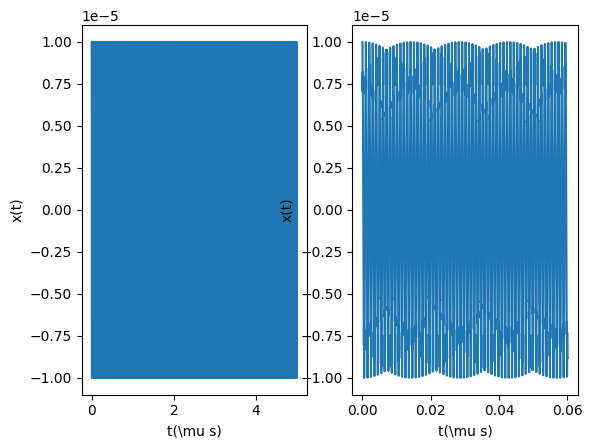

In [5]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_init*1e6, x_init)
# ax[0].plot(t_init*1e6, vx_init)

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = round(0.6e-7/dt)
ax[1].plot(t_init[:Zoomnum]*1e6, x_init[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('x(t)')

# Show the plot
plt.show()

Get the spectrum of the motion, using ```scipy.fft.fft ```and ```scipy.fft.fftfreq```

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html

using ```scipy.signal.find_peaks``` to find peaks and make captions

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

About how to normalize the spectrum of a FT spectrum, there are several ways:

- divide the amplitude by duration

- divide the amplitude by maximum

- divide the amplitude by standard deviation

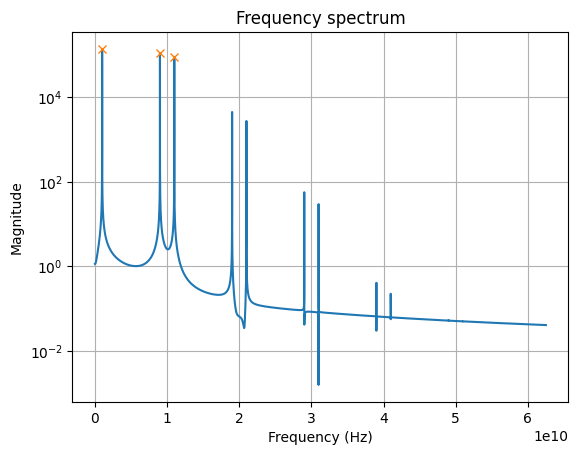

In [12]:
# Get the fourier spectrum of velocity

vxf_init = fft(vx_init)
vyf_init = fft(vy_init)
vzf_init = fft(vz_init)
tf = fftfreq(len(vx_init), dt / Amplifier_Num_init)

Front = 0
Cutoff = 8
vf = vxf_init[Front:Front + (vxf_init.size//Cutoff//2)]
ttf = tf[:len(vx_init)//2]
ttf = ttf[Front:Front + (ttf.size//Cutoff)]

# Get normalized magnitude of specturm
N_vf_init = 2.0/(Amplifier_Num_init * (N+1)) * np.abs(vf[0:len(vx_init)//2])


# use find_peaks to get all the peaks
peaks, _ = find_peaks(N_vf_init, height=0)


# we only need the three largest peaks, therefore we find a border and find peaks again
temp = N_vf_init[peaks]
temp.sort()
temp = temp[::-1]
border = ( temp[3] + temp[2])/2
#border = 0
peaks, heights = find_peaks(N_vf_init, height= border)

#print("The location of the three largest peaks is {}, {}, {} Hz".format(tf[peaks[0]], tf[peaks[1]], tf[peaks[2]]))

# Plot the result
plt.plot(ttf, N_vf_init)
plt.plot(ttf[peaks], N_vf_init[peaks], "x")

#for i in range(0,3):                                      
    #plt.text(ttf[peaks[i]], N_vf_init[peaks[i]], "%f" % N_vf[peaks[i]])
    #plt.text(ttf[peaks[i]], N_vf_init[peaks[i]], "%f" % ttf[peaks[i]])

# Regenerate the resonator's frequency by the third peak position
fres = ttf[peaks[peak_count]]

# Calculate the average of the velocity in the first micromotion peroid
Tradical = 1 / ttf[peaks[0]]
#Nsec = round(Tradical / dt * Amplifier_Num_init)

#vx_Nsec = list(vx_init[: Nsec])
#vy_Nsec = list(vy_init[: Nsec])
#vz_Nsec = list(vz_init[: Nsec])

#vx_init_Ampl = sum(abs(ele) for ele in vx_Nsec) / Nsec
#vy_init_Ampl = sum(abs(ele) for ele in vy_Nsec) / Nsec
#vz_init_Ampl = sum(abs(ele) for ele in vz_Nsec) / Nsec

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

In [7]:
print(tf[1]- tf[0])

199999.960000008


- induced current : $I = ev/d_{eff}$
- induced voltage : $U = IR = I Re(Z) = Re(Z) ev/d_{eff}$
- induced force : $F = -e U/d = - Re(Z) \frac{e^2}{d_{eff}^2} v$

$ Re(Z)$ can have time dependence, thus acting on the electron by different pattern. In a RLC parallel circuit, the impetence $ Z $ in the frequency domin is given by:

$$ Z_{LC} = (\frac{1}{R_p} + i\omega C + \frac{1}{i\omega L})^{-1} = \frac{R_p}{[1+iQ(\frac{\omega}{\omega_R} - \frac{\omega_R}{\omega} )]} $$

Real part and imaginary part:

$$ Re(Z_{LC}) = \frac{R_p}{1 + Q^2(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2} $$

$$ Im(Z_{LC}) = - \frac{R_p Q(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})}{1 + Q^2(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2} $$

where $dw$ means the detuning from $w_R$, $dw = w - w_R$

In the time domin: 

$$F(t) = -e U/d = - Re[Z](t) \frac{e^2}{d_{eff}^2} v(t)$$

According to https://www.princeton.edu/~cuff/ele201/kulkarni_text/frequency.pdf,

$$ x(t)y(t) \leftrightarrow \frac{1}{2\pi}X(\omega) * Y(\omega) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} X(\eta) Y(\omega - \eta) d\eta $$



A force damping is needed for real circumstances, the damping force should be modified by a velocity factor $ \bar{v}(t)/\bar{v}(0)$, So the force should be $$F(v) = F(v_0) \times |\bar{v}(t)/\bar{v}(0)|,$$ where $F(v_0)$ means the damping force was initially calculated by only veclocity without damping force, not the real force concerning real velocity, the bar means we need to calculate the velocity amplitude average in a rf period.

In [8]:
tf[0] = 1e-5

Rezf = Rp / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
Imzf = Rp *  Q  * (tf / fres - fres / tf) / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
Rezf = np.array(Rezf)
Imzf = np.array(Imzf)
zf = Rezf + 1j * Imzf

# This is for convolution of the spectrum
#Damping_Exf =np.convolve(vxf_init, zf)

# This is for multiply of the spectrum
Damping_Exf = np.multiply(vxf_init, zf)

Damping_Ex_t = np.real(ifft(Damping_Exf))
Damping_Ex = list(Damping_Ex_t.real)
# An additional general -1 should be added, because this is damping force
Damping_Ex =[- q / deff ** 2 * a for a in Damping_Ex]
Damping_Ex_Ampl = (abs(max(Damping_Ex)) + abs(min(Damping_Ex))) / 2
phase = np.arcsin(Damping_Ex[0] / Damping_Ex_Ampl)
#phase = 0.
# Generate the JNNoise to be added into the simulation

Amplifier_Num_init = 1
U_rms = np.sqrt(4 * kB * Temperature * Rp * Amplifier_Num_init / dt)

# Considering Non-Markovian JN-noise, there is a correlation time -> correlation number in the list
Ncorr = round(1 / fres * Q / dt * Amplifier_Num_init) # 1 / fres is the correlation time, so /dt brings Ncorr


#if Ncorr % 2 == 0:
#    Ncorr = Ncorr + 1
def noise_on_trap(U_rms, samplerate, samples, R, fres, bandwidth = U_rms):
    t = np.linspace(0, samples / samplerate, int(samples))
    
    signal = np.random.normal(0, bandwidth, size = len(t))
    X = np.fft.fft(signal)
    N = len(X)
    freqs = np.fft.fftfreq(N) * samplerate
    freqs[0] = 1e-5
    f_U_noise = U_rms * X / ( 1 +  1j * Q * R * (freqs / fres - fres / freqs))
    U_noise = np.fft.ifft(f_U_noise)
    return np.real(U_noise)

JNNoise_Ex = 1 / deff * noise_on_trap(U_rms= U_rms, samplerate= Amplifier_Num_init / dt, samples= 1.05 * T / dt * Amplifier_Num_init, R = Rp, fres = fres)
JNNoise_Ey = 1 / deff * noise_on_trap(U_rms= U_rms, samplerate= Amplifier_Num_init / dt, samples= 1.05 * T / dt * Amplifier_Num_init, R = Rp, fres = fres)
JNNoise_Ez = 1 / deff * noise_on_trap(U_rms= U_rms, samplerate= Amplifier_Num_init / dt, samples= 1.05 * T / dt * Amplifier_Num_init, R = Rp, fres = fres)


ValueError: x and y must have same first dimension, but have shapes (5000001,) and (2100000,)

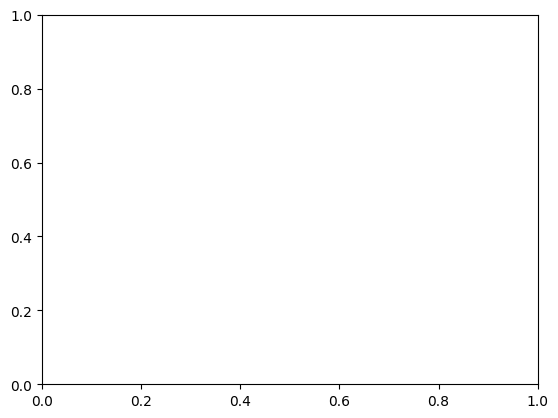

In [9]:

plt.plot(np.array(t_eval_init) * 1e6, JNNoise_Ex[:len(t_eval_init)])
plt.xlabel('Time( $\mu$s)')
plt.ylabel('Noise field')
plt.title('Noise with time')
plt.grid()
plt.show()


In [ ]:
DampingFactor_x_min, DampingFactor_y_min, DampingFactor_z_min = 1., 1., 1.
temp = 0
last_posi = -1
DampingFactor_list = []
DampingFactor_tlist = []
# Calculate the damping force coefficient 
def DampingFactor(Vec_init, Vec, t):
    # This for damping facroe
   
    #posi = round(t/dt * Amplifier_Num_init)
    posi = int(t / dt * Amplifier_Num_init)
    #print(posi)
    global DampingFactor_x_min
    global DampingFactor_y_min
    global DampingFactor_z_min
    global vx_init_Ampl
    global vy_init_Ampl
    global vz_init_Ampl
    x, y, z, vx, vy, vz = Vec
    '''
    vx_Nsec.pop(0)
    vy_Nsec.pop(0)
    vz_Nsec.pop(0)
    vx_Nsec.append(vx)
    vy_Nsec.append(vy)
    vz_Nsec.append(vz)
    vx_Ampl = sum(abs(ele) for ele in vx_Nsec) / Nsec
    vy_Ampl = sum(abs(ele) for ele in vy_Nsec) / Nsec
    vz_Ampl = sum(abs(ele) for ele in vz_Nsec) / Nsec
    #DampingFactor_list.append(np.sqrt(vx_Ampl ** 2 / vx_init_Ampl ** 2 + vy_Ampl ** 2 / vy_init_Ampl ** 2 + vz_Ampl ** 2 / vz_init_Ampl ** 2))
    
    return vx_Ampl / vx_init_Ampl, vy_Ampl / vy_init_Ampl, vz_Ampl / vz_init_Ampl
    '''
    # Do a linear approximation 
    #vx_init_temp = vx_init[posi] + (vx_init[posi + 1] - vx_init[posi]) * (t/dt * Amplifier_Num_init - posi)
    #vy_init_temp = vy_init[posi] + (vx_init[posi + 1] - vx_init[posi]) * (t/dt * Amplifier_Num_init - posi)
    #vz_init_temp = vz_init[posi] + (vx_init[posi + 1] - vx_init[posi]) * (t/dt * Amplifier_Num_init - posi)

    _, _, _, vx_init, vy_init, vz_init = Vec_init
    if abs(vx / vx_init) > 1000 or abs(vx_init) < 1e-6:
        return 1000., 1000., 1000.
        #return 0., 0., 0.

    
    #Temp_Compare_list.pop(0)
    #Temp_Compare_list.append(temp)
    
    #if np.std(Temp_Compare_list) < 5e-2 and abs(vx / vx_init_temp) < 5e-2:
        #return 0., 0., 0.

        #DampingFactor_x_min = min(abs(vx / vx_init_temp), DampingFactor_x_min)
        #DampingFactor_y_min = min(abs(vy / vy_init_temp), DampingFactor_y_min)
        #DampingFactor_z_min = min(abs(vy / vz_init_temp), DampingFactor_z_min)
        #return DampingFactor_x_min, DampingFactor_y_min, DampingFactor_z_min
    #return min(1., abs(vx /  vx_init_temp) ), min(1., abs(vy / vy_init_temp) ),min(1., abs(vz / vz_init_temp) )
    return vx /  vx_init , 0., 0.
    #return abs(vx /  vx_init_temp) / 2 , abs(vy / vy_init_temp) / 2 , abs(vz / vz_init_temp) / 2
    
    #return round(abs(vx / vx_init[posi]),round_num), round(abs(vy / vy_init[posi]),round_num), round(abs(vz / vz_init[posi]), round_num)
    #DampingFactor_list.append(np.sqrt(vx ** 2 / vx_init_Ampl ** 2 + vy ** 2 / vy_init_Ampl ** 2 + vz ** 2 / vz_init_Ampl ** 2))
    #return np.sqrt(vx ** 2 / vx_init_Ampl ** 2 + vy ** 2 / vy_init_Ampl ** 2 + vz ** 2 / vz_init_Ampl ** 2)
    #return 1.,1.,1.

# Calculate the Damping force generated by tank circuit

def DampingForce_list(Vec_init, Vec, t):
    global last_posi
    global DampingFactor_list
    global DampingFactor_tlist
    posi = int(t/dt * Amplifier_Num_init)
    last_posi = posi
    # This is for damping factor method
    DampingFactorx, DampingFactory, DampingFactorz = DampingFactor(Vec_init, Vec, t)
    #if 9990 < posi < 10050:
        #print('posi = {}'.format(posi))
        #print('DampingFactorx={}'.format(DampingFactorx))
        #print('temp:{}'.format(temp))
        #print('t = {} us'.format(t * 1e6))
        #print(DampingFactor_x_min)
        #print(vx)

    DampingFactor_tlist.append(t)
    DampingFactor_list.append(DampingFactorx)
    Damping_Ex_init = Damping_Ex[posi] + (Damping_Ex[posi + 1] - Damping_Ex[posi]) * (t/dt * Amplifier_Num_init - posi)
    #Damping_Ey_init = Damping_Ey[posi] + (Damping_Ey[posi + 1] - Damping_Ex[posi]) * (t/dt * Amplifier_Num_init - posi)
    #Damping_Ez_init = Damping_Ez[posi] + (Damping_Ez[posi + 1] - Damping_Ex[posi]) * (t/dt * Amplifier_Num_init - posi)
    return DampingFactorx * Damping_Ex_init, 0., 0.
    # This is for time-segment method
    #return Damping_Ex_temp[posi], 0., 0.
    # This is for time-domain method
    # Damping_Ex.append(Rez_t[posi] * vx)
    # return Rez_t[posi] * vx, 0., 0.
def DampingForce(Vec_init, Vec, t):
    global Damping_Ex_Ampl
    global fres
    x_init, y_init, z_init, vx_init, vy_init, vz_init = Vec_init
    x, y, z, vx, vy, vz = Vec
    #DampingFactor_tlist.append(t)
    
    if abs(vx / vx_init) > 10 or abs(vx_init) < 1e-6 or vx_init == 0:
        #DampingFactor_list.append(10)
        #return 0., 0.,0.
        if vx_init == 0:
            return 0., 0., 0.
        if vx / vx_init > 0:
            return Damping_Ex_Ampl * 10 * np.sin(2 * np.pi * fres * t), 0., 0.
        if vx / vx_init < 0:
            return - Damping_Ex_Ampl * 10 * np.sin(2 * np.pi * fres * t), 0., 0.

    #DampingFactor_list.append(vx / vx_init)
    return Damping_Ex_Ampl * vx / vx_init * np.sin(2 * np.pi * fres * t + phase), 0., 0.

#Calculate the JN noise of the circuit
def JNNoise(Vec, t):
    posi = int(t/dt * Amplifier_Num_init)

    return JNNoise_Ex[posi] + (JNNoise_Ex[posi + 1] - JNNoise_Ex[posi]) * (t/dt * Amplifier_Num_init - posi), 0., 0.
    #return 0., 0., 0.

# Calculate motional deviation according to Edc and Erf
def DevMotion(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t),
                                    DampingForce(Vec, t),
                                    JNNoise(Vec, t))))
    
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az

def DevMotion_para(t, Vec_para):
    
    x_init, y_init, z_init, vx_init, vy_init, vz_init, x, y, z, vx, vy, vz = Vec_para
    Vec_init = x_init, y_init, z_init, vx_init, vy_init, vz_init
    Vec = x, y, z, vx, vy, vz
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t),
                                    DampingForce(Vec_init, Vec, t),
                                    #JNNoise(Vec, t)
                                    )))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m

    Ex_init, Ey_init, Ez_init = tuple(map(sum, zip(Edc(Vec_init, t),
                                                   Erf(Vec_init, t),
                                                  )))
    ax_init = q * Ex_init / m
    ay_init = q * Ey_init / m
    az_init = q * Ez_init / m
    progress_bar.update(dt)
    return vx_init, vy_init, vz_init, ax_init, ay_init, az_init, vx, vy, vz, ax, ay, az

def rk45_fixed_step(f, t0, y0, t_max, dt):
    t = [t0]
    y_x0, y_y0, y_z0, y_vx0, y_vy0, y_vz0 = y0
    y_x = [y_x0]
    y_y = [y_y0]
    y_z = [y_z0]
    y_vx = [y_vx0]
    y_vy = [y_vy0]
    y_vz = [y_vz0]

    while t[-1] + dt < t_max:
        k1_x, k1_y, k1_z, k1_vx, k1_vy, k1_vz = f(t[-1], (y_x[-1], y_y[-1], y_z[-1], y_vx[-1], y_vy[-1], y_vz[-1]))
        k1_x, k1_y, k1_z, k1_vx, k1_vy, k1_vz = dt * k1_x, dt * k1_y, dt *  k1_z, dt * k1_vx, dt * k1_vy, dt * k1_vz 
        k2_x, k2_y, k2_z, k2_vx, k2_vy, k2_vz = f(t[-1] + 0.25 * dt, (y_x[-1] + 0.25 * k1_x, y_y[-1] + 0.25 * k1_y, y_z[-1] + 0.25 * k1_z, y_vx[-1] + 0.25 * k1_vx, y_vy[-1] + 0.25 * k1_vy, y_vz[-1] + 0.25 * k1_vz))
        k2_x, k2_y, k2_z, k2_vx, k2_vy, k2_vz = dt *k2_x, dt * k2_y, dt * k2_z, dt * k2_vx, dt * k2_vy, dt * k2_vz
        k3_x, k3_y, k3_z, k3_vx, k3_vy, k3_vz = f(t[-1] + 0.75 * dt, (y_x[-1] + 0.75 * k2_x, y_y[-1] + 0.75 * k2_y, y_z[-1] + 0.75 * k2_z, y_vx[-1] + 0.75 * k2_vx, y_vy[-1] + 0.75 * k2_vy, y_vz[-1] + 0.75 * k2_vz))
        k3_x, k3_y, k3_z, k3_vx, k3_vy, k3_vz = dt *k3_x, dt * k3_y, dt * k3_z, dt * k3_vx, dt * k3_vy, dt * k3_vz
        k4_x, k4_y, k4_z, k4_vx, k4_vy, k4_vz = f(t[-1] + dt,\
                                                    (y_x[-1] + k1_x/6 + k2_x/3 + k3_x/3,\
                                                            y_y[-1] + k1_y/6 + k2_y/3 + k3_y/3,\
                                                                y_z[-1] + k1_z/6 + k2_z/3 + k3_z/3,\
                                                                    y_vx[-1] + k1_vx/6 + k2_vx/3 + k3_vx/3,\
                                                                        y_vy[-1] + k1_vy/6 + k2_vy/3 + k3_vy/3,\
                                                                            y_vz[-1] + k1_vz/6 + k2_vz/3 + k3_vz/3,))
        k4_x, k4_y, k4_z, k4_vx, k4_vy, k4_vz = dt *k4_x, dt * k4_y, dt * k4_z, dt * k4_vx, dt * k4_vy, dt * k4_vz
        next_x = y_x[-1] + k1_x/6 + k2_x/3 + k3_x/3 + k4_x/6
        next_y = y_y[-1] + k1_y/6 + k2_y/3 + k3_y/3 + k4_y/6
        next_z = y_z[-1] + k1_z/6 + k2_z/3 + k3_z/3 + k4_z/6
        next_vx = y_vx[-1] + k1_vx/6 + k2_vx/3 + k3_vx/3 + k4_vx/6
        next_vy = y_vy[-1] + k1_vy/6 + k2_vy/3 + k3_vy/3 + k4_vy/6
        next_vz = y_vz[-1] + k1_vz/6 + k2_vz/3 + k3_vz/3 + k4_vz/6
        
        t.append(t[-1] + dt)
        y_x.append(next_x)
        y_y.append(next_y)
        y_z.append(next_z)
        y_vx.append(next_vx)
        y_vy.append(next_vy)
        y_vz.append(next_vz)

    return np.array(t), np.array(y_x), np.array(y_y), np.array(y_z), np.array(y_vx), np.array(y_vy), np.array(y_vz)


def rk45_fixed_step_para(f, t0, y0, t_max, dt):
    t = [t0]
    y_x0_init, y_y0_init, y_z0_init, y_vx0_init, y_vy0_init, y_vz0_init, y_x0, y_y0, y_z0, y_vx0, y_vy0, y_vz0 = y0
    y_x_init = [y_x0_init]
    y_y_init = [y_y0_init]
    y_z_init = [y_z0_init]
    y_vx_init = [y_vx0_init]
    y_vy_init = [y_vy0_init]
    y_vz_init = [y_vz0_init]
    y_x = [y_x0]
    y_y = [y_y0]
    y_z = [y_z0]
    y_vx = [y_vx0]
    y_vy = [y_vy0]
    y_vz = [y_vz0]

    while t[-1] + dt < t_max:
        k1_x_init, k1_y_init, k1_z_init, k1_vx_init, k1_vy_init, k1_vz_init, k1_x, k1_y, k1_z, k1_vx, k1_vy, k1_vz \
            = f(t[-1],(y_x_init[-1], y_y_init[-1], y_z_init[-1], y_vx_init[-1], y_vy_init[-1], y_vz_init[-1], y_x[-1], y_y[-1], y_z[-1], y_vx[-1], y_vy[-1], y_vz[-1]))
        k1_x_init, k1_y_init, k1_z_init, k1_vx_init, k1_vy_init, k1_vz_init, k1_x, k1_y, k1_z, k1_vx, k1_vy, k1_vz \
            = dt * k1_x_init, dt * k1_y_init, dt *  k1_z_init, dt * k1_vx_init, dt * k1_vy_init, dt * k1_vz_init, dt * k1_x, dt * k1_y, dt *  k1_z, dt * k1_vx, dt * k1_vy, dt * k1_vz 
        k2_x_init, k2_y_init, k2_z_init, k2_vx_init, k2_vy_init, k2_vz_init, k2_x, k2_y, k2_z, k2_vx, k2_vy, k2_vz \
            = f(t[-1] + 0.25 * dt, \
                (y_x_init[-1] + 0.25 * k1_x_init, y_y_init[-1] + 0.25 * k1_y_init, y_z_init[-1] + 0.25 * k1_z_init, y_vx_init[-1] + 0.25 * k1_vx_init, y_vy_init[-1] + 0.25 * k1_vy_init, y_vz_init[-1] + 0.25 * k1_vz_init,\
                y_x[-1] + 0.25 * k1_x, y_y[-1] + 0.25 * k1_y, y_z[-1] + 0.25 * k1_z, y_vx[-1] + 0.25 * k1_vx, y_vy[-1] + 0.25 * k1_vy, y_vz[-1] + 0.25 * k1_vz))
        k2_x_init, k2_y_init, k2_z_init, k2_vx_init, k2_vy_init, k2_vz_init, k2_x, k2_y, k2_z, k2_vx, k2_vy, k2_vz \
            = dt *k2_x_init, dt * k2_y_init, dt * k2_z_init, dt * k2_vx_init, dt * k2_vy_init, dt * k2_vz_init, dt *k2_x, dt * k2_y, dt * k2_z, dt * k2_vx, dt * k2_vy, dt * k2_vz
        k3_x_init, k3_y_init, k3_z_init, k3_vx_init, k3_vy_init, k3_vz_init, k3_x, k3_y, k3_z, k3_vx, k3_vy, k3_vz \
            = f(t[-1] + 0.75 * dt, \
                (y_x_init[-1] + 0.75 * k2_x_init, y_y_init[-1] + 0.75 * k2_y_init, y_z_init[-1] + 0.75 * k2_z_init, y_vx_init[-1] + 0.75 * k2_vx_init, y_vy_init[-1] + 0.75 * k2_vy_init, y_vz_init[-1] + 0.75 * k2_vz_init,\
                y_x[-1] + 0.75 * k2_x, y_y[-1] + 0.75 * k2_y, y_z[-1] + 0.75 * k2_z, y_vx[-1] + 0.75 * k2_vx, y_vy[-1] + 0.75 * k2_vy, y_vz[-1] + 0.75 * k2_vz))
        k3_x_init, k3_y_init, k3_z_init, k3_vx_init, k3_vy_init, k3_vz_init, k3_x, k3_y, k3_z, k3_vx, k3_vy, k3_vz \
            = dt *k3_x_init, dt * k3_y_init, dt * k3_z_init, dt * k3_vx_init, dt * k3_vy_init, dt * k3_vz_init, dt *k3_x, dt * k3_y, dt * k3_z, dt * k3_vx, dt * k3_vy, dt * k3_vz
        k4_x_init, k4_y_init, k4_z_init, k4_vx_init, k4_vy_init, k4_vz_init, k4_x, k4_y, k4_z, k4_vx, k4_vy, k4_vz = f(t[-1] + dt,\
                                                    (y_x_init[-1] + k1_x_init/6 + k2_x_init/3 + k3_x_init/3,\
                                                            y_y_init[-1] + k1_y_init/6 + k2_y_init/3 + k3_y_init/3,\
                                                                y_z_init[-1] + k1_z_init/6 + k2_z_init/3 + k3_z_init/3,\
                                                                    y_vx_init[-1] + k1_vx_init/6 + k2_vx_init/3 + k3_vx_init/3,\
                                                                        y_vy_init[-1] + k1_vy_init/6 + k2_vy_init/3 + k3_vy_init/3,\
                                                                            y_vz_init[-1] + k1_vz_init/6 + k2_vz_init/3 + k3_vz_init/3,\
                                                    y_x[-1] + k1_x/6 + k2_x/3 + k3_x/3,\
                                                            y_y[-1] + k1_y/6 + k2_y/3 + k3_y/3,\
                                                                y_z[-1] + k1_z/6 + k2_z/3 + k3_z/3,\
                                                                    y_vx[-1] + k1_vx/6 + k2_vx/3 + k3_vx/3,\
                                                                        y_vy[-1] + k1_vy/6 + k2_vy/3 + k3_vy/3,\
                                                                            y_vz[-1] + k1_vz/6 + k2_vz/3 + k3_vz/3))
        k4_x_init, k4_y_init, k4_z_init, k4_vx_init, k4_vy_init, k4_vz_init, k4_x, k4_y, k4_z, k4_vx, k4_vy, k4_vz \
            = dt * k4_x_init, dt * k4_y_init, dt * k4_z_init, dt * k4_vx_init, dt * k4_vy_init, dt * k4_vz_init, dt * k4_x, dt * k4_y, dt * k4_z, dt * k4_vx, dt * k4_vy, dt * k4_vz
        next_x_init = y_x_init[-1] + k1_x_init/6 + k2_x_init/3 + k3_x_init/3 + k4_x_init/6
        next_y_init = y_y_init[-1] + k1_y_init/6 + k2_y_init/3 + k3_y_init/3 + k4_y_init/6
        next_z_init = y_z_init[-1] + k1_z_init/6 + k2_z_init/3 + k3_z_init/3 + k4_z_init/6
        next_vx_init = y_vx_init[-1] + k1_vx_init/6 + k2_vx_init/3 + k3_vx_init/3 + k4_vx_init/6
        next_vy_init = y_vy_init[-1] + k1_vy_init/6 + k2_vy_init/3 + k3_vy_init/3 + k4_vy_init/6
        next_vz_init = y_vz_init[-1] + k1_vz_init/6 + k2_vz_init/3 + k3_vz_init/3 + k4_vz_init/6
        next_x = y_x[-1] + k1_x/6 + k2_x/3 + k3_x/3 + k4_x/6
        next_y = y_y[-1] + k1_y/6 + k2_y/3 + k3_y/3 + k4_y/6
        next_z = y_z[-1] + k1_z/6 + k2_z/3 + k3_z/3 + k4_z/6
        next_vx = y_vx[-1] + k1_vx/6 + k2_vx/3 + k3_vx/3 + k4_vx/6
        next_vy = y_vy[-1] + k1_vy/6 + k2_vy/3 + k3_vy/3 + k4_vy/6
        next_vz = y_vz[-1] + k1_vz/6 + k2_vz/3 + k3_vz/3 + k4_vz/6
        
        t.append(t[-1] + dt)
        y_x_init.append(next_x_init)
        y_y_init.append(next_y_init)
        y_z_init.append(next_z_init)
        y_vx_init.append(next_vx_init)
        y_vy_init.append(next_vy_init)
        y_vz_init.append(next_vz_init)
        y_x.append(next_x)
        y_y.append(next_y)
        y_z.append(next_z)
        y_vx.append(next_vx)
        y_vy.append(next_vy)
        y_vz.append(next_vz)

    return np.array(t), np.array(y_x_init), np.array(y_y_init), np.array(y_z_init),\
         np.array(y_vx_init), np.array(y_vy_init), np.array(y_vz_init), np.array(y_x),\
             np.array(y_y), np.array(y_z), np.array(y_vx), np.array(y_vy), np.array(y_vz)


Then Johnson-Nyquist noise is added in the motional simulation, https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise

For a given bandwidth, the root mean square (RMS) of the voltage, $v_{n}$, is given by
$$v_{n}={\sqrt {\overline {v_{n}^{2}}}}{\sqrt {\Delta f}}={\sqrt {4k_{\text{B}}TR\Delta f}}$$

which means we can generate the noise distribution with a gaussion distri, where the RMS is given by $ {\sqrt {4k_{\text{B}}TR\Delta f}}$, and $\Delta f$ is given by $f_{res} / Q$ according to one of the definitions of quality factor Q, https://en.wikipedia.org/wiki/Q_factor

concerning how to add noise to a signal in Python, there is an answer says: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

Two kinds of noise creation was recommended:
1. Markovian Noise
2. Non-Markovian Noise with correlation time $T_{corr} = 1 / \delta f_{res} = Q / f_{res}$ ; 

There is a website that supports the Non-Markovian Noise, https://www.frontiersin.org/research-topics/41181/the-role-of-non-markovian-noise-in-quantum-information-processing-tasks

(No-access)White, G. Characterization and control of non-Markovian quantum noise. Nat Rev Phys 4, 287 (2022). https://doi.org/10.1038/s42254-022-00446-2

Chang Woo Kim, et. al Analog Quantum Simulation of the Dynamics of Open Quantum Systems with Quantum Dots and Microelectronic Circuits https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.3.040308

In [ ]:
# Setting the process bar with tqdm
progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)
# Using RK45 to solve the ODE
Amplifier_Num = 1

t_eval = np.linspace(0, T, Amplifier_Num * (N + 1))

# This is for damping factor and time domain method
Vec0 = x0, y0, z0, vx0, vy0, vz0, x0, y0, z0, vx0, vy0, vz0

solution = solve_ivp(fun=lambda t, Vec: DevMotion_para(t, Vec), 
                     t_span = (0, T), 
                     y0 = Vec0, 
                     t_eval = t_eval, 
                     first_step = dt,
                     max_step = dt,
                     atol = 1e1,
                     rtol = 1e1,
                     method = 'RK45')

t_damp = solution.t
VecResult = solution.y

x_damp, y_damp, z_damp = VecResult[6, :], VecResult[7, :], VecResult[8, :]
vx_damp, vy_damp, vz_damp = VecResult[9, :], VecResult[10, :], VecResult[11, :]


progress_bar.close()

In [ ]:
'''# Print the damping factor
Cutoff = -1
plt.plot(np.array(DampingFactor_tlist[:Cutoff])* 1e6, DampingFactor_list[:Cutoff] ,'k.', label = 'DampingFactor')
plt.plot([t_damp[0] * 1e6, t_damp[-1] * 1e6], [1, 1], 'r--', label = '1')
plt.xlabel('t/$\mu$s')
plt.ylabel('Damping Factor')
plt.title(' Fres = {}'.format(fres))
plt.ylim([0, 10])
plt.legend()
plt.show()
'''

In [ ]:
'''
Cutoff = 90000 - 100
print(DampingFactor_list[Cutoff:Cutoff + 200])
'''

In [ ]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(np.array(t_eval[:len(x_damp) // 500 * 500])*1e6, x_damp[:len(x_damp) // 500 * 500])
#ax[0].plot(np.array(t_eval[:len(x_damp)])*1e6, x_damp[:len(x_damp)])

# Add labels to the axes
ax[0].set_xlabel('t($\mu$s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = round(0.02e-6/dt)
ax[1].plot(np.array(t_eval[:Zoomnum // 1 * 1])*1e6, x_damp[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t($\mu$s)')
ax[1].set_ylabel('x(t)')


# Show the plot
plt.show()


In [ ]:
vx_abs_init = (np.abs(np.max(vx_damp)) + np.abs(np.min(vx_damp))) / 2
e = 2.71828182845904523536

peaks, heights = find_peaks(vx_damp, height= vx_abs_init/np.sqrt(e))

In [ ]:


plt.plot(np.array(t_damp[:len(x_damp) // 500 * 500])*1e6, vx_damp[:len(x_damp) // 500 * 500],\
          label = '$\omega_r$:{}GHz, $\omega_m$:{}GHz, $\omega_z$:{}MHz'.format(wrf/2/np.pi/1e9, wradical/2/np.pi/1e9, waxial/2/np.pi/1e6))
#plt.plot(np.array(t_damp[:len(x_damp) // 500 * 500])*1e6, vx_abs_init / e * np.ones(len(x_damp))[:len(x_damp) // 500 * 500], 'r--', label = '1/e')
plt.plot(np.array(t_damp[:len(x_damp) // 500 * 500])*1e6, -vx_abs_init / e * np.ones(len(x_damp))[:len(x_damp) // 500 * 500], 'r--')
plt.plot(np.array(t_damp[peaks[-1]])*1e6, vx_damp[peaks[-1]], "x")
#plt.text(np.array(t_damp[peaks[-1]])*1e6, vx_damp[peaks[-1]], "%.2f $\mu$s" % (float(t_damp[peaks[-1]]) * 1e6))
#ax[0].plot(np.array(t_eval[:len(x_damp)])*1e6, x_damp[:len(x_damp)])

# Add labels to the axes
#plt.set_xlabel('t($\mu$s)')
#plt.set_ylabel('$v_x$(t)')
plt.xlabel('Time($\mu$s)')
plt.ylabel('$v_x$(t)')
plt.legend()
plt.ylim([-2e5, 2e5])
plt.title('{:.2f} Hz, {:.1f} M$\Omega$'.format(fres, Rp/1e6))
Zoomnum = round(0.2e-6/dt)
x_zoom = np.array(t_eval[:Zoomnum // 1 * 1])*1e6
y_zoom = vx_damp[:Zoomnum]
axes = plt.axes([.50, .2, .23, .2])
axes.plot(x_zoom, y_zoom, c='blue', lw=1, label='Zoomed curve')
axes.set_xlabel('$\mu$s')
#axes.legend(‘right’)

plt.grid()

plt.show()

In [ ]:
plt.plot(Damping_Ex)
plt.show()

In [ ]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2, sharey= False)

# Plot the data on the axes
ax[0].plot(np.array(t_damp[:len(x_damp) // 500 * 500])*1e6, vx_damp[:len(x_damp) // 500 * 500])
#ax[0].plot(np.array(t_eval[:len(x_damp)])*1e6, x_damp[:len(x_damp)])

# Add labels to the axes
ax[0].set_xlabel('t($\mu$s)')
ax[0].set_ylabel('$v_x$(t)')

# Plot the data on the axes
Zoomnum = round(1e-6/dt)
ax[1].plot(np.array(t_damp[:Zoomnum // 25 * 25])*1e6, vx_damp[:Zoomnum // 25 * 25])

# Add labels to the axes
ax[1].set_xlabel('t($\mu$s)')
ax[1].set_ylabel('vx(t)')

# Show the plot
plt.show()

In [ ]:
print('cooling time for secular = {} us'.format(m * deff ** 2/ q ** 2/ Rp * 1e6))

Secular energy calculations / could also use the average energy over a period of secular motion for now

The total energy $E_{tot}$ is given by:

$$ E_{tot} = \sum_i [V_{DC}(\vec{r_i}) + V_{rf}(\vec{r_i},t) + V_{kin}(v_i) + \frac{1}{2}\sum_{j\not = i} V_{Coul} (\vec{r_i},\vec{r_j})], $$


In [ ]:
# Define the pesudo-potential

def Vps(Vec, t):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = Erf(Vec, t)
    return q ** 2 / 4 / m / wrf ** 2 * (Ex ** 2 + Ey ** 2 + Ez ** 2)

# Calculte for the kinetic energy

def Ekin(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return 0.5 * m * (vx ** 2 + vy ** 2 + vz ** 2)

E_sec = []
for i in range(N - Nsec):
    E_sec_temp = 0
    for j in range(Nsec):
        Vec = x_damp[i + j], y_damp[i + j], z_damp[i + j], vx_damp[i + j], vy_damp[i + j], vz_damp[i + j]
        E_sec_temp = E_sec_temp + Vdc(Vec, t_eval[i + j]) + Vrf(Vec, t_eval[i + j]) + Ekin(Vec, t_eval[i + j])
    E_sec.append(E_sec_temp / Nsec)





In [ ]:
# plot the secular energy
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_eval[: N - Nsec]*1e6, E_sec[: N - Nsec])

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('E(t)')

# Plot the data on the axes
Zoomnum = int(0.12e-6/dt)
ax[1].plot(t_eval[:Zoomnum]*1e6, E_sec[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('E(t)')

# Show the plot
plt.show()

# Functions for fitting data

60
60
A exp[-0.5((x-mu)/sigma)^2] + k 
Parent Coefficients:
1.000, 0.200, 0.300, 0.625
Fit Coefficients:
881927.0399657617 -1.8357967487177835 0.16707340848758853 0.4498884636246055


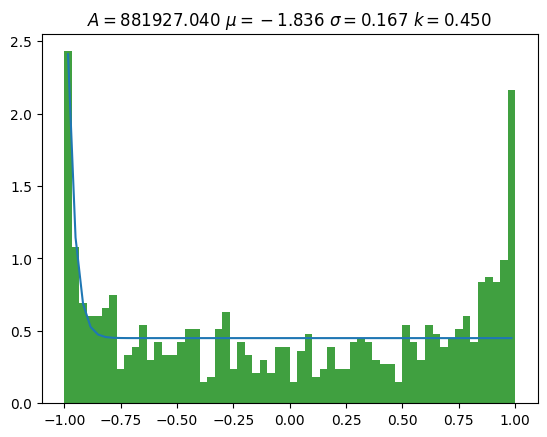

In [7]:
from pylab import *
from numpy import loadtxt
from scipy.optimize import leastsq

fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))


Energy = np.sin(np.random.normal(0, 2 * np.pi, 1000))
n, bin_edges,_ = plt.hist(Energy, 60, density=True, color='green', alpha=0.75)
xdata = 0.5*(bin_edges[1:] + bin_edges[:-1])
ydata = n
print(len(xdata))
print(len(n))

init  = [1.0, 0.5, 0.5, 0.5]

out   = leastsq( errfunc, init, args=(xdata, ydata))
c = out[0]

print("A exp[-0.5((x-mu)/sigma)^2] + k ")
print("Parent Coefficients:")
print("1.000, 0.200, 0.300, 0.625")
print("Fit Coefficients:")
print(c[0],c[1],abs(c[2]),c[3])

plot(xdata, fitfunc(c, xdata))
#plot(xdata, ydata)

title(r'$A = %.3f\  \mu = %.3f\  \sigma = %.3f\ k = %.3f $' %(c[0],c[1],abs(c[2]),c[3]))

show()